In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from skimage import io

import numpy as np

import os

In [27]:
imagePaths = []
for city in os.listdir("./Data/"):
    path = os.path.join("./Data/", city)
    imagePaths.extend([os.path.join(path, imageFile).replace("\\", "/") for imageFile in os.listdir(path)])
    print(len(imagePaths))

13630
40810
49773
72943
123143
128668
157730
209412
214099
222477


In [32]:
# imagePaths

In [23]:
path

'./Data/Seattle'

In [22]:
os.listdir(path)[0]

'47.496523657197415,-122.26054075212448.jpg'

In [26]:
os.path.join(path, os.listdir(path)[0])

'./Data/Seattle\\47.496523657197415,-122.26054075212448.jpg'

In [12]:
del imagePaths

In [33]:
os.path.join("./Data/", "Boston").split("/")[2]

'Boston'

In [51]:
class CitiesData(Dataset):
    def __init__(self, dataParentFolder: str, dataIdxs: list, transform = None):
        self.dataParentFolder = dataParentFolder
        self.transform = transform

        imagePaths = []
        for city in os.listdir(dataParentFolder):
            path = os.path.join(dataParentFolder, city)
            imagePaths.extend([os.path.join(path, imageFile).replace("\\", "/") for imageFile in os.listdir(path)])
            
        self.imagePaths = np.array(imagePaths)[dataIdxs]

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        imagePath = self.imagePaths[idx]
        city = imagePath.split("/")[2]

        image = io.imread(imagePath)
        if self.transform:
            image = self.transform(image)
    
        return image, city

In [36]:
dataParentFolder = "./Data/"

cityIdxs = [0]
totalPoints = 0
for city in os.listdir(dataParentFolder):
    totalPoints += len(os.listdir(os.path.join(dataParentFolder, city)))
    cityIdxs.append(totalPoints)


In [39]:
cityIdxs

[0, 13630, 40810, 49773, 72943, 123143, 128668, 157730, 209412, 214099, 222477]

In [49]:
trainIdxs = []
testIdxs = []
for i in range(len(cityIdxs) - 1):
    start = cityIdxs[i]
    stop = cityIdxs[i + 1]

    num_train = int(np.round((stop - start) / 100 * 90))
    # Shuffle all training stimulus images
    idxs = np.arange(start, stop)

    # print(start)
    # print(stop)
    # print(len(idxs))
    # print(num_train)
    # print(idxs[:15])

    np.random.shuffle(idxs)
    # print(idxs[:15])
    # print()

    # Assign 90% of the shuffled stimulus images to the training partition,
    # and 10% to the test partition
    trainIdxs.extend(idxs[:num_train])
    testIdxs.extend(idxs[num_train:])
    # trainIdxs, valIdxs = idxs[:num_train], idxs[num_train:]

In [46]:
len(trainIdxs)

200229

In [47]:
len(testIdxs)

22248

In [48]:
len(imagePaths)

222477

In [52]:
data = CitiesData(dataParentFolder, trainIdxs)

In [53]:
dataloader = DataLoader(data, batch_size=128, shuffle=True)

In [55]:
for p in dataloader:
    image, city = p
    print(image)
    print("City")
    print(city)
    print()
    break

tensor([[[[228, 227, 223],
          [228, 227, 223],
          [228, 227, 223],
          ...,
          [228, 227, 223],
          [228, 227, 223],
          [228, 227, 223]],

         [[228, 227, 223],
          [228, 227, 223],
          [228, 227, 223],
          ...,
          [228, 227, 223],
          [228, 227, 223],
          [228, 227, 223]],

         [[228, 227, 223],
          [228, 227, 223],
          [228, 227, 223],
          ...,
          [228, 227, 223],
          [228, 227, 223],
          [228, 227, 223]],

         ...,

         [[232, 231, 229],
          [227, 226, 224],
          [225, 224, 222],
          ...,
          [ 64,  64,  62],
          [ 78,  78,  76],
          [ 70,  70,  68]],

         [[231, 230, 228],
          [232, 231, 229],
          [229, 228, 226],
          ...,
          [ 73,  73,  71],
          [ 81,  81,  79],
          [ 53,  53,  51]],

         [[219, 218, 216],
          [230, 229, 227],
          [235, 234, 232],
         

In [57]:
import matplotlib.pyplot as plt

Phoenix


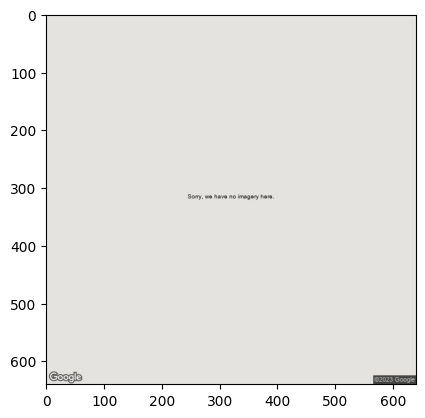

In [63]:
print(city[0])
plt.imshow(image[0])

LosAngeles


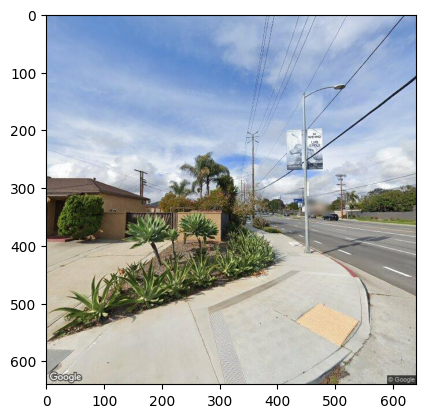

In [64]:
print(city[1])
plt.imshow(image[1])